In [1]:
import pathlib
import typing
import os
import json
import pickle

import sipyco.pyon as pyon
import qiskit.pulse as qp
import numpy as np
import euriqabackend.waveforms.conversions as wf_convert
import matplotlib
import matplotlib.pyplot as plt

import euriqafrontend.interactive.rfsoc.qiskit_backend as qbe
import euriqafrontend.interactive.rfsoc.submit as rfsoc_submit

import euriqabackend.waveforms.single_qubit as single_qb_wf
import euriqabackend.waveforms.multi_qubit as multi_qb_wf
import qiskit.pulse as qp

import functools
import euriqafrontend.circuits.circuit_plotter as plotter
from qiskit import QuantumCircuit
import euriqabackend.waveforms.conversions as conv
import pulsecompiler.qiskit.transforms.gate_barrier as barrier
import qiskit.compiler as q_compile

/home/mcetina/git/euriqa-artiq/euriqafrontend/__init__.py:29: UserWarning: No environment variable (EURIQA_NAS_DIR) defined for where the EURIQA NAS is mounted. I guessed '/media/euriqa-nas/' based on your platform
  _ENVIRONMENT_VARIABLE_NAS_DIR, _nas_dir


In [2]:
#############################################
### Channel definitions ######
from offlinemodule.interface import RFSOCoffline

offlineModule = RFSOCoffline()
offlineModule.build()
offlineModule.prepare()
qp_backend = offlineModule.qiskit_backend
master_ip = offlineModule.master_ip

/home/mcetina/git/euriqa-artiq/euriqafrontend/settings/rf_calibration.json


In [3]:
def center_to_19_pair(fnc):
    def _decorated_fnc(ions:typing.Sequence[int], th:float, *args, **kwargs):
        return fnc([i-9 for i in ions], theta=th*0.5, *args, **kwargs)
    return _decorated_fnc

def center_to_19_idx(fnc):
    def _decorated_fnc(ion_index:int, *args, **kwargs):
        return fnc(ion_index-9, *args, **kwargs)
    return _decorated_fnc

def myrz(ion_index:int, angle:float):
    return single_qb_wf.rz(ion_index, -angle, backend=qp_backend)

single_qubit_gates = {
    "id": single_qb_wf.id_gate,
    "r": center_to_19_idx(functools.partial(single_qb_wf.sk1_gaussian, backend = qp_backend, ind_amp_multiplier = 1.0)),
    "rx": center_to_19_idx(functools.partial(single_qb_wf.sk1_gaussian, phi=-np.pi / 2, backend = qp_backend, ind_amp_multiplier = 1.0)),
    "ry": center_to_19_idx(functools.partial(single_qb_wf.sk1_gaussian, phi=0, backend = qp_backend, ind_amp_multiplier = 1.0)),
    "rz": center_to_19_idx(myrz)
}

multi_qubit_gates = {
    "rxx": center_to_19_pair(functools.partial(multi_qb_wf.xx_am_gate, backend = qp_backend)),
}

from pulsecompiler.qiskit.instruction_schedule import IonInstructionScheduleMap

instruction_schedule = IonInstructionScheduleMap(
        offlineModule.zero_qiskit_backend,
        single_qubit_gates,
        multi_qubit_gates
    )
instruction_schedule._backend = qp

In [21]:
nq = 19
layers = 3
import numpy as np

scheduled_scan_circuits=[]

scan_values = np.arange(0,2*np.pi, 2*np.pi/11)

for theta in scan_values:

    qiskit_circuit = QuantumCircuit(nq)                    

    for i in range(nq):
        qiskit_circuit.ry(wf_convert.hack_angle(np.pi/2,0),i)

    qiskit_circuit.barrier()
    
    for layer in range(layers):
        for i in range(nq-1):
            qiskit_circuit.rxx(0,i,i+1)
            qiskit_circuit.barrier()

    for i in range(nq):
        qiskit_circuit.rz(theta,i)
        qiskit_circuit.ry(wf_convert.hack_angle(-np.pi/2,layers),i)

    circuit_sequential = barrier.BarrierBetweenGates().run_circuit(qiskit_circuit)
    circuit_scheduled = q_compile.schedule(
        circuit_sequential,
        qp_backend, inst_map=instruction_schedule
    )
    scheduled_scan_circuits.append(circuit_scheduled)    

scheduled_scan_circuits.__len__()

11

In [22]:
rid = rfsoc_submit.submit_schedule(
        scheduled_scan_circuits,
        master_ip,
        qp_backend,
        experiment_kwargs={
            "xlabel": "red and blue detuning",
            "x_values": pyon.encode(scan_values),            
            "default_sync": False,
            "num_shots": 500,
            "PMT Input String": "-1:17",
            "lost_ion_monitor": True,
            "schedule_transform_aom_nonlinearity": True,
            "schedule_transform_keep_global_beam_on": False,
            "schedule_transform_pad_schedule": True,
            "schedule_transform_fill_unused_channels": True,
            "do_sbc": True,
            "do_SBC": False,
            "priority": 0,
            "record_upload_sequence": False,
            "auto_reload": True,
            "lost_ion_monitor": True,
            "auto_reload_when_lost_ion": True

        })
#rfsoc_submit.wait_for_completion(rid)

Ion Backend defaults are not currently implemented


In [19]:
print(rid)

448785


In [6]:
import datetime
server = pathlib.Path(r"/media/euriqa-nas/CompactTrappedIonModule")
data_path = server / "Data" / "artiq_data" 

In [7]:
data = plotter.get_binary_data(data_path,rid,date=datetime.date.today())
#plotter.plot_correlations(data,register_index=plot_index, title = "RID {0}".format(rid));
#plotter.plot_parity(data,register_index=register.index[plaquette_all], title = "RID {0}".format(rid));

#### plot scanned values in GUI
x_label = "phase (rad)"

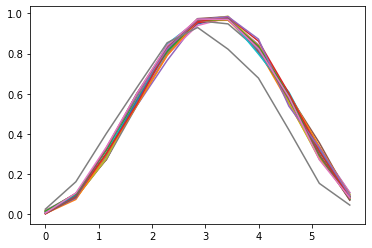

In [8]:
for i in range(1,19,1):
    plt.plot(scan_values,np.mean(data[i,:,:],axis=0))

In [123]:
import scipy.optimize as opt
fits=[]
for i in range(0,19,1):
    fits.append((opt.curve_fit((lambda x, o, c, x0: o + 0.5*(1-np.cos(x-x0))),scan_values,np.mean(data[i,:,:],axis=0)))[0])

/nix/store/ssxs7bs9pdfk5psn0bj0sybhlxk3qhla-python3-3.7.6-env/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


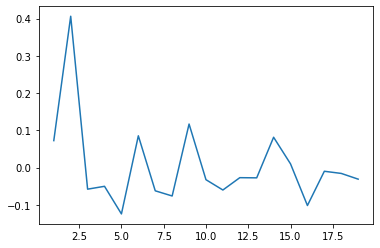

In [124]:
# -10 shift => -0.42 rad / -10 Hz shift
plt.plot(np.arange(1,20,1),np.array(fits)[:,-1])

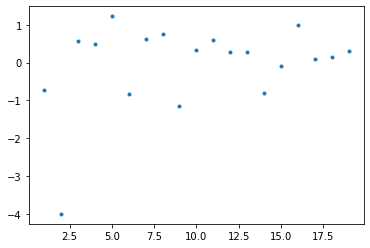

In [125]:
plt.plot(np.arange(1,20,1),-np.array(fits)[:,-1]*10/0.42*13/19*145/240,'.')

In [127]:
f0s = [-26.1481, -29.7638, -30.8977, -33.3153, -35.6055, -36.4602, -38.2603, -40.5437, -41.1401, -42.0204, -42.1296, -43.0361, -42.7806, -44.3842, -44.5787, -44.728, -44.4603, -44.504, -43.4087]
print(len(f0s))
corr = -np.array(fits)[:,-1]*10/0.42*13/19*145/240 - 3.5
print(corr + f0s)

19
[-30.35998894 -37.2604714  -33.82780758 -36.32062729 -37.88181702
 -40.7994402  -41.14702279 -43.2936497  -45.78994722 -45.20035607
 -45.03723674 -46.26961064 -46.00962598 -48.6849952  -48.17695739
 -47.22631663 -47.86301368 -47.84970615 -46.60310786]


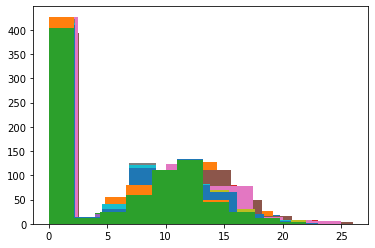

In [90]:
raw_data = plotter.get_raw_counts(data_path,rid,date=datetime.date.today())
for i in range(1,14,1):
    plt.hist(np.ndarray.flatten(raw_data[i,:,:]))